Install package pytorch_tabnet, commented after installation to avoid re-running. Uncomment in a new notebook runtime.

In [ ]:
# !pip install pytorch_tabnet

Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from google.colab import drive 
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

Mount google drive storage.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Training Data

In [ ]:
df_X = pd.read_csv("/content/drive/MyDrive/MSc-project-lof/df_X_iter5_v2_before smote_transformed_ready to train.csv")

In [ ]:
df_y = pd.read_csv("/content/drive/MyDrive/MSc-project-lof/df_y_iter5_v2_before smote_transformed_ready to train.csv")

In [ ]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 47 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   col_0                                      4740 non-null   int64  
 1   col_1                                      4740 non-null   int64  
 2   col_2                                      4740 non-null   int64  
 3   col_3                                      4740 non-null   int64  
 4   col_4                                      4740 non-null   int64  
 5   col_5                                      4740 non-null   int64  
 6   col_6                                      4740 non-null   int64  
 7   col_7                                      4740 non-null   int64  
 8   Chromosome                                 4740 non-null   int64  
 9   VEP Annotation                             4740 non-null   int64  
 10  Allele Count            

In [ ]:
df_X['Chromosome'].nunique()

23

In [ ]:
df_X['Chromosome'].value_counts()

2     495
10    446
8     328
4     313
20    282
17    281
3     274
19    250
16    223
1     214
11    203
7     192
0     178
12    160
5     156
18    149
9     137
15    104
6      86
21     86
13     75
14     68
22     40
Name: Chromosome, dtype: int64

Convert training to numpy arrays

In [ ]:
X = df_X.to_numpy(dtype='float64')
y = df_y.to_numpy().reshape(-1,)
X.shape, y.shape

((4740, 47), (4740,))

In [ ]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split between training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [ ]:
X_train.shape, y_train.shape

((3318, 47), (3318,))

In [ ]:
X_val.shape, y_val.shape

((1422, 47), (1422,))

In [ ]:
class_names = ['LikelyPatho','Pathogenic','Benign']

Function to disply confusion matrix.

In [ ]:
def display_confusion_matrix(classifier,X_test, y_test,class_names):
  titles_options = [("Confusion matrix, without normalization", None,'d'),
                    ("Normalized confusion matrix", 'true','.2f')]                 
  for title, normalize, format in titles_options:
      disp = plot_confusion_matrix(classifier, X_test, y_test,
                                  display_labels=class_names,
                                  cmap=plt.cm.Blues,
                                  values_format=format,
                                  normalize=normalize,
                                  xticks_rotation = 'vertical')
      disp.ax_.set_title(title)
  plt.show()

Lists to save validation accuracies and F1 scores  of the models.

In [ ]:
val_acc = []
f1_list = []

Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42,C=1e5,max_iter=20000)
model_lr.fit(X_train,y_train)

y_train_pred = model_lr.predict(X_train)
y_val_pred = model_lr.predict(X_val)

Training Accuracy:  0.8520192887281495
Validation Accuracy:  0.8241912798874824
F1-Score: 0.8006122280135683


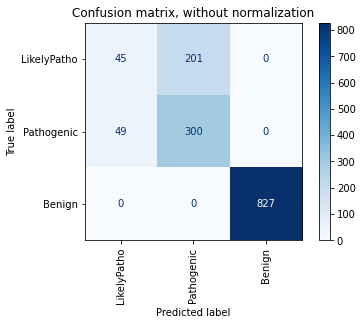

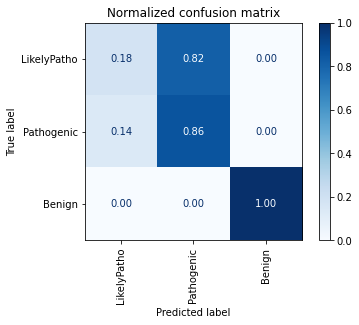

              precision    recall  f1-score   support

           0       0.48      0.18      0.26       246
           1       0.60      0.86      0.71       349
           2       1.00      1.00      1.00       827

    accuracy                           0.82      1422
   macro avg       0.69      0.68      0.66      1422
weighted avg       0.81      0.82      0.80      1422



In [ ]:
print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
display_confusion_matrix(model_lr,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

Hyperparameter tuning for Support Vector Machine (SVM)

In [ ]:
from sklearn import svm

param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.849, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.833, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.849, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.855, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.855, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.837, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.839, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.836, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.836, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   21.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

SVM model

Training Accuracy:  0.9092827004219409
Validation Accuracy:  0.8396624472573839
F1-Score: 0.8357463239994886


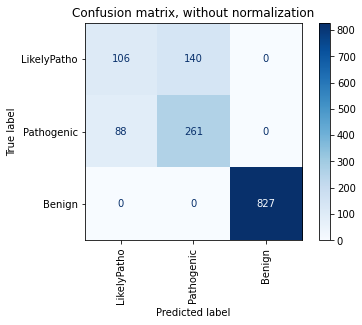

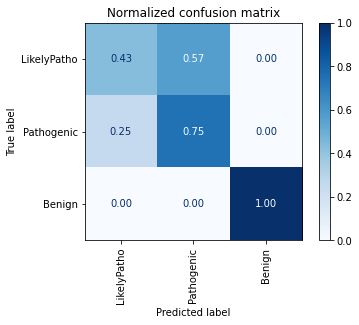

              precision    recall  f1-score   support

           0       0.55      0.43      0.48       246
           1       0.65      0.75      0.70       349
           2       1.00      1.00      1.00       827

    accuracy                           0.84      1422
   macro avg       0.73      0.73      0.73      1422
weighted avg       0.84      0.84      0.84      1422



In [ ]:
model_svm = svm.SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
model_svm.fit(X_train,y_train)

y_train_pred = model_svm.predict(X_train)
y_val_pred = model_svm.predict(X_val)

print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
display_confusion_matrix(model_svm,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

KNN Model

Training Accuracy:  0.8842676311030742
Validation Accuracy:  0.849507735583685
F1-Score: 0.8441197729665827


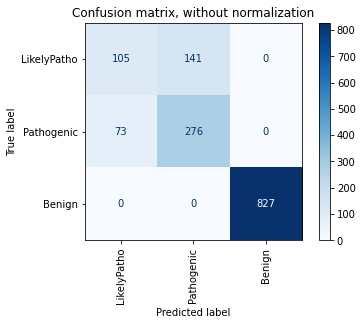

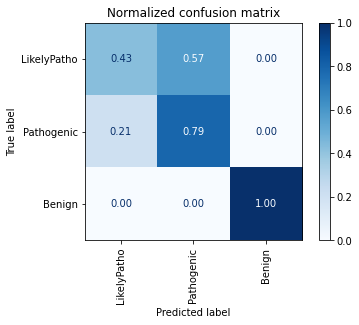

              precision    recall  f1-score   support

           0       0.59      0.43      0.50       246
           1       0.66      0.79      0.72       349
           2       1.00      1.00      1.00       827

    accuracy                           0.85      1422
   macro avg       0.75      0.74      0.74      1422
weighted avg       0.85      0.85      0.84      1422



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=9)
model_knn.fit(X_train,y_train)

y_train_pred = model_knn.predict(X_train)
y_val_pred = model_knn.predict(X_val)

print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
display_confusion_matrix(model_knn,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

Gaussian Naive Bayes

Training Accuracy:  0.8007836045810729
Validation Accuracy:  0.7862165963431786
F1-Score: 0.7647312058721708


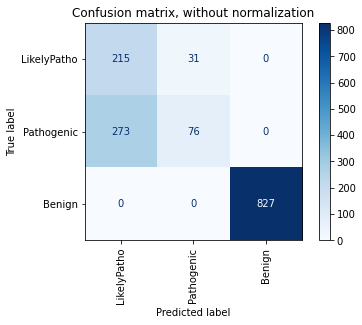

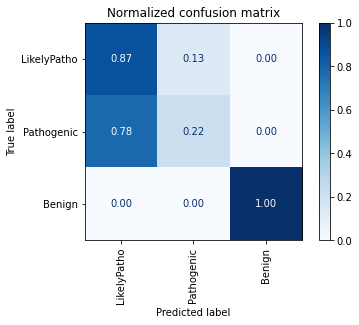

              precision    recall  f1-score   support

           0       0.44      0.87      0.59       246
           1       0.71      0.22      0.33       349
           2       1.00      1.00      1.00       827

    accuracy                           0.79      1422
   macro avg       0.72      0.70      0.64      1422
weighted avg       0.83      0.79      0.76      1422



In [ ]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB(var_smoothing=0.00001)

model_nb.fit(X_train,y_train)

y_train_pred = model_nb.predict(X_train)
y_val_pred = model_nb.predict(X_val)

print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
display_confusion_matrix(model_nb,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

Random Foreest Classifier

Training Accuracy:  1.0
Validation Accuracy:  0.849507735583685
F1-Score: 0.8458320760346076


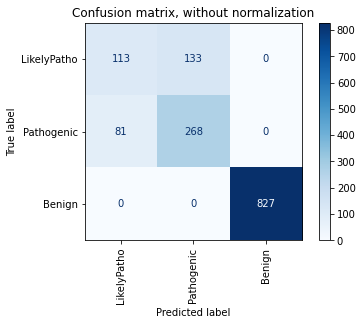

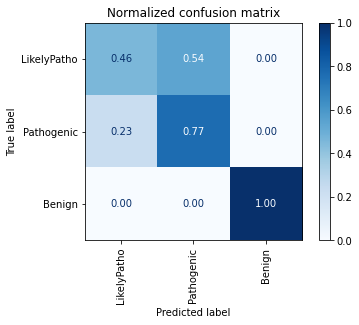

              precision    recall  f1-score   support

           0       0.58      0.46      0.51       246
           1       0.67      0.77      0.71       349
           2       1.00      1.00      1.00       827

    accuracy                           0.85      1422
   macro avg       0.75      0.74      0.74      1422
weighted avg       0.85      0.85      0.85      1422



In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(n_estimators=50, random_state=0,n_jobs=-1)
model_rfc.fit(X_train, y_train)

y_train_pred = model_rfc.predict(X_train)
y_val_pred = model_rfc.predict(X_val)

print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
display_confusion_matrix(model_rfc,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

Hyper parameter tuning for XGB model. Code has been commneted to avoid re-running as it takes roughly 2 hours on Colab Pro with high RAM. Results have been saved after tuning.

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid = [{ "max_depth": [30,50,60],
#                 "learning_rate": [0.1, 0.05,0.01],
#                 "gamma": [0.25,0.5, 1],
#                 "reg_lambda": [1,5,7,10],
#                 "scale_pos_weight": [1, 3, 5],
#                 "subsample": [0.7,0.9],
#                 "colsample_bytree": [0.5]
# }]

# xgb_grid = XGBClassifier(objective='multi:softmax',num_class=3)
# # xgb_grid = XGBClassifier()

# grid_xgb = GridSearchCV(xgb_grid,param_grid,refit=True,verbose=3,n_jobs=-1,scoring='roc_auc_ovr_weighted')
# grid_xgb.fit(X_train,y_train)
# print(grid_xgb.best_params_)

Results of Hyper parameters tuning:

{'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 30, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.7}

XGB model using tuned hyper parameters.

Training Accuracy:  0.9041591320072333
Validation Accuracy:  0.870604781997187
F1-Score: 0.8622077597046665


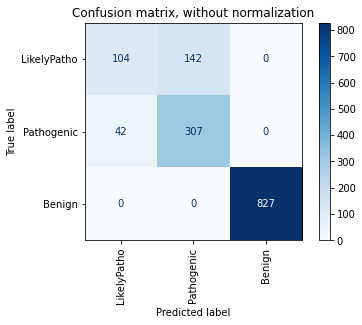

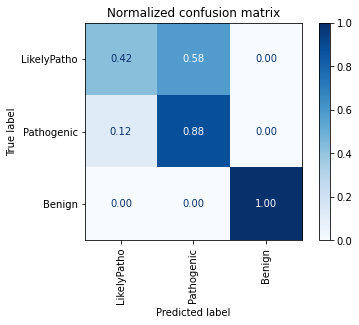

              precision    recall  f1-score   support

           0       0.71      0.42      0.53       246
           1       0.68      0.88      0.77       349
           2       1.00      1.00      1.00       827

    accuracy                           0.87      1422
   macro avg       0.80      0.77      0.77      1422
weighted avg       0.87      0.87      0.86      1422



In [ ]:
model_xgb_tuned = XGBClassifier(
                    colsample_bytree=0.5,
                    gamma = 1,
                    learning_rate = 0.01,
                    max_depth = 30,
                    reg_lambda = 10,
                    scale_pos_weight = 1,
                    subsample = 0.7,
                    n_jobs = -1
                    )
model_xgb_tuned.fit(X_train, y_train)

y_train_pred = model_xgb_tuned.predict(X_train)
y_val_pred = model_xgb_tuned.predict(X_val)

print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
display_confusion_matrix(model_xgb_tuned,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

Tab Net classfier based on deep learning architecture.

In [ ]:
model_tabnet = TabNetClassifier() 
model_tabnet.fit(
  X_train, y_train,
  eval_set=[(X_val, y_val)]
)


y_train_pred = model_tabnet.predict(X_train)
y_val_pred = model_tabnet.predict(X_val)

print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

f1_list.append(f1_score(y_val,y_val_pred,average="weighted"))
val_acc.append(np.mean(y_val_pred==y_val))
print(classification_report(y_val,y_val_pred))

Device used : cpu
epoch 0  | loss: 1.09882 | val_0_accuracy: 0.59916 |  0:00:00s
epoch 1  | loss: 0.70882 | val_0_accuracy: 0.61744 |  0:00:00s
epoch 2  | loss: 0.48824 | val_0_accuracy: 0.80872 |  0:00:01s
epoch 3  | loss: 0.36708 | val_0_accuracy: 0.79114 |  0:00:01s
epoch 4  | loss: 0.31721 | val_0_accuracy: 0.81646 |  0:00:01s
epoch 5  | loss: 0.28032 | val_0_accuracy: 0.81786 |  0:00:02s
epoch 6  | loss: 0.27254 | val_0_accuracy: 0.82419 |  0:00:02s
epoch 7  | loss: 0.2714  | val_0_accuracy: 0.82911 |  0:00:02s
epoch 8  | loss: 0.27263 | val_0_accuracy: 0.827   |  0:00:03s
epoch 9  | loss: 0.27535 | val_0_accuracy: 0.81927 |  0:00:03s
epoch 10 | loss: 0.27541 | val_0_accuracy: 0.83052 |  0:00:03s
epoch 11 | loss: 0.2697  | val_0_accuracy: 0.827   |  0:00:04s
epoch 12 | loss: 0.26982 | val_0_accuracy: 0.82771 |  0:00:04s
epoch 13 | loss: 0.26985 | val_0_accuracy: 0.8263  |  0:00:04s
epoch 14 | loss: 0.26848 | val_0_accuracy: 0.827   |  0:00:04s
epoch 15 | loss: 0.27537 | val_0_accu

Plot comparison of validation accuracies and F1 scores.

<Figure size 432x288 with 0 Axes>

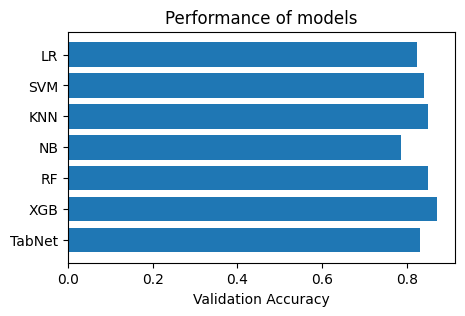

In [ ]:
plt.figure()
plt.rcdefaults()
fig, ax = plt.subplots()

models = ('LR', 'SVM', 'KNN', 'NB', "RF","XGB","TabNet")
y_pos = np.arange(len(models))

fig.set_size_inches(5,3)
ax.barh(y_pos, val_acc, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis() 
ax.set_xlabel('Validation Accuracy')
ax.set_title('Performance of models')

plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

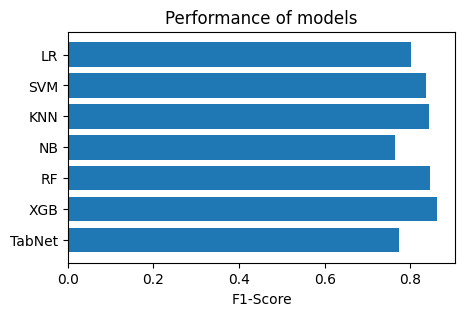

In [ ]:
plt.figure()
plt.rcdefaults()
fig, ax = plt.subplots()

models = ('LR', 'SVM', 'KNN', 'NB', "RF","XGB","TabNet")
y_pos = np.arange(len(models))

fig.set_size_inches(5,3)
ax.barh(y_pos, f1_list, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis() 
ax.set_xlabel('F1-Score')
ax.set_title('Performance of models')

plt.show()
plt.close()

Load Inpdependent Test Set (ITS)

In [ ]:
df_X_test = pd.read_csv("/content/drive/MyDrive/MSc-project-lof/df_X_test_iter5_v1_transformed_ready to train.csv")
df_y_test = pd.read_csv("/content/drive/MyDrive/MSc-project-lof/df_y_test_iter5_v1_transformed_ready to train.csv")

In [ ]:
X_test = df_X_test.to_numpy()
y_test = df_y_test.to_numpy().reshape(-1,)
X_test.shape, y_test.shape

((300, 47), (300,))

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

Before testing, train best models (XGB and RFC) on full training data (training set + testing set).

In [ ]:
X_full = np.concatenate((X_train,X_val),axis=0)

In [ ]:
X_full.shape

(4740, 47)

In [ ]:
y_full = np.concatenate((y_train,y_val),axis=0)
y.shape

(4740,)

Training Accuracy:  0.8989451476793249
F1-Score: 0.8926865498987031


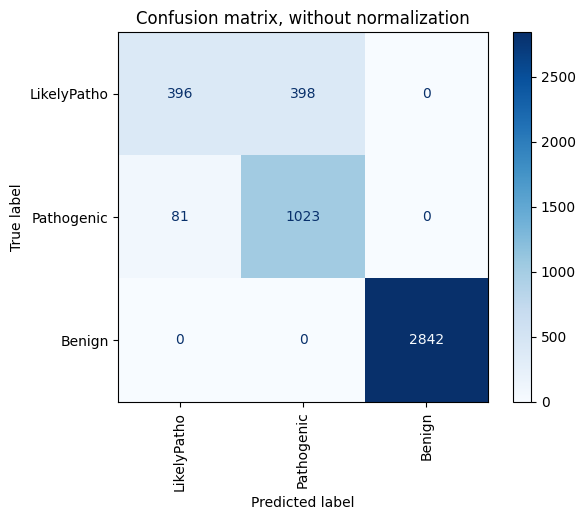

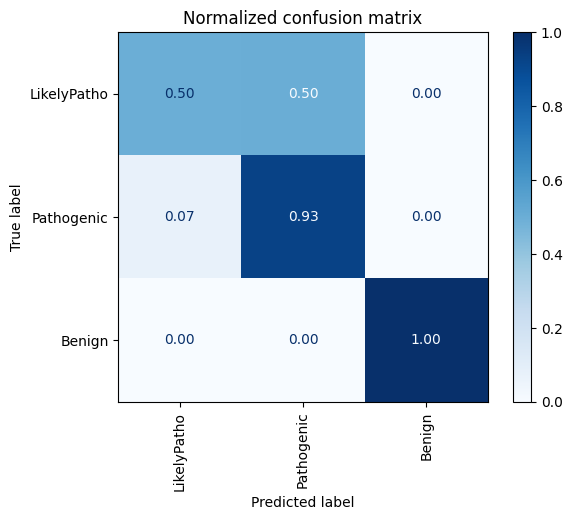

              precision    recall  f1-score   support

           0       0.83      0.50      0.62       794
           1       0.72      0.93      0.81      1104
           2       1.00      1.00      1.00      2842

    accuracy                           0.90      4740
   macro avg       0.85      0.81      0.81      4740
weighted avg       0.91      0.90      0.89      4740



In [ ]:
model_xgb_full = XGBClassifier(
                    colsample_bytree=0.5,
                    gamma = 1,
                    learning_rate = 0.01,
                    max_depth = 30,
                    reg_lambda = 10,
                    scale_pos_weight = 1,
                    subsample = 0.7,
                    n_jobs = -1
                    )
model_xgb_full.fit(X_full, y_full)

y_train_pred = model_xgb_full.predict(X_full)

print("Training Accuracy: ", np.mean(y_train_pred==y_full))
print("F1-Score:",f1_score(y_full,y_train_pred,average="weighted"))

display_confusion_matrix(model_xgb_full,X_full,y_full,class_names)
print(classification_report(y_full,y_train_pred))

Test the XGB model using ITS.

Testing Accuracy:  0.89
F1-Score: 0.8836350587602044


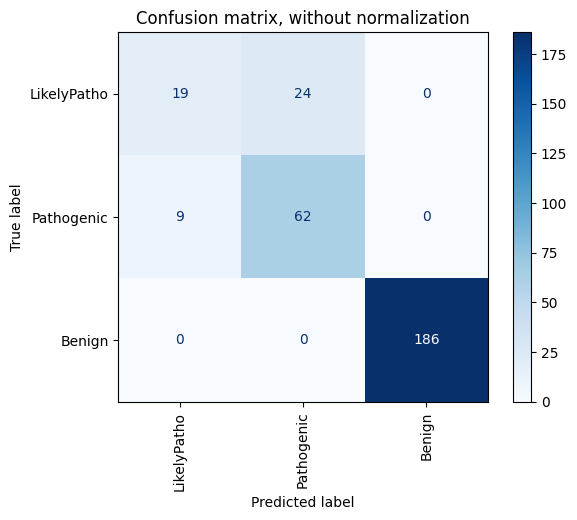

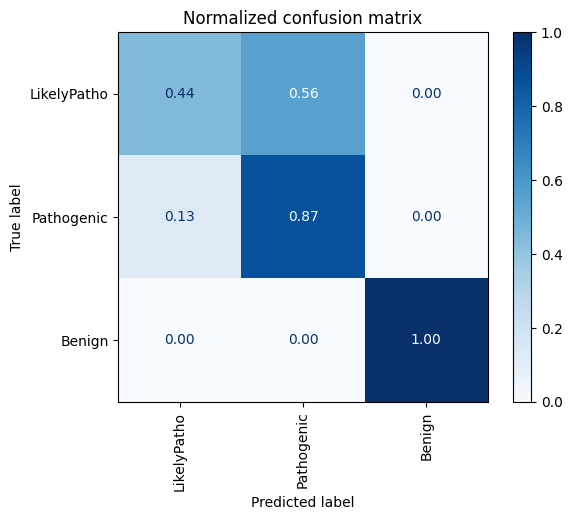

              precision    recall  f1-score   support

           0       0.68      0.44      0.54        43
           1       0.72      0.87      0.79        71
           2       1.00      1.00      1.00       186

    accuracy                           0.89       300
   macro avg       0.80      0.77      0.78       300
weighted avg       0.89      0.89      0.88       300



In [ ]:
y_test_pred = model_xgb_full.predict(X_test)

print("Testing Accuracy: ", np.mean(y_test_pred==y_test))
print("F1-Score:",f1_score(y_test,y_test_pred,average="weighted"))

display_confusion_matrix(model_xgb_full,X_test,y_test,class_names)
print(classification_report(y_test,y_test_pred))

Train RFC on full data.

Training Accuracy:  0.9548523206751055
F1-Score: 0.9546075002255953


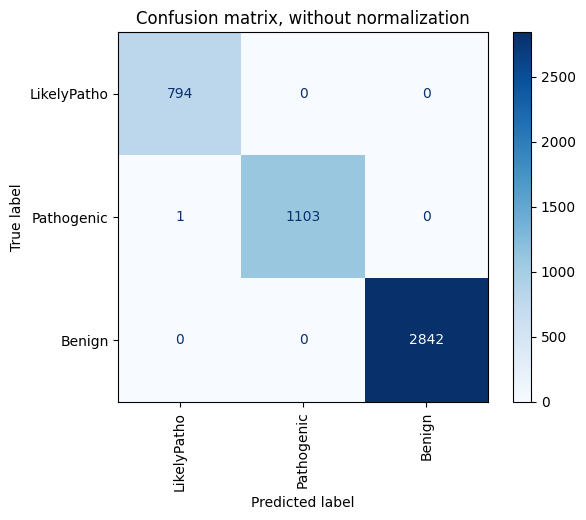

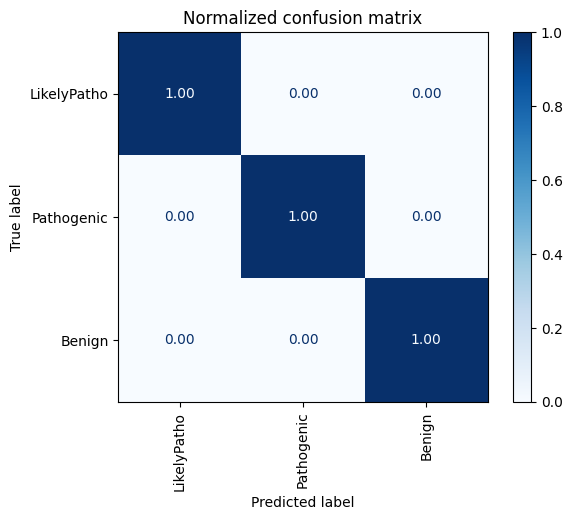

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       794
           1       0.88      0.93      0.91      1104
           2       1.00      1.00      1.00      2842

    accuracy                           0.95      4740
   macro avg       0.93      0.92      0.92      4740
weighted avg       0.95      0.95      0.95      4740



In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_full = RandomForestClassifier(n_estimators=30, random_state=0,n_jobs=-1)
model_rfc_full.fit(X_full, y_full)

y_train_pred = model_rfc.predict(X_full)

print("Training Accuracy: ", np.mean(y_train_pred==y_full))
print("F1-Score:",f1_score(y_full,y_train_pred,average="weighted"))

display_confusion_matrix(model_rfc_full,X_full,y_full,class_names)
print(classification_report(y_full,y_train_pred))

Test RFC on ITS.

Testing Accuracy:  0.8633333333333333
F1-Score: 0.8604887718403987


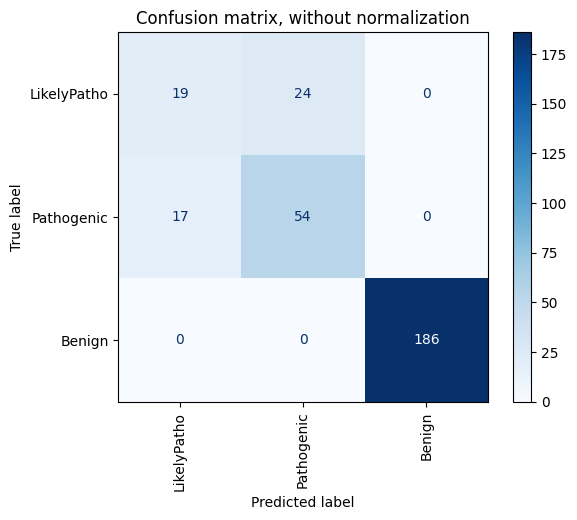

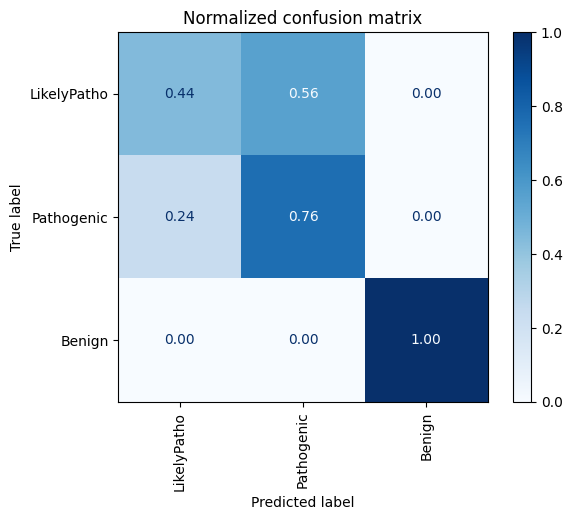

              precision    recall  f1-score   support

           0       0.53      0.44      0.48        43
           1       0.69      0.76      0.72        71
           2       1.00      1.00      1.00       186

    accuracy                           0.86       300
   macro avg       0.74      0.73      0.74       300
weighted avg       0.86      0.86      0.86       300



In [ ]:
y_test_pred = model_rfc_full.predict(X_test)

print("Testing Accuracy: ", np.mean(y_test_pred==y_test))
print("F1-Score:",f1_score(y_test,y_test_pred,average="weighted"))

display_confusion_matrix(model_rfc_full,X_test,y_test,class_names)
print(classification_report(y_test,y_test_pred))

Ensembles using Voting and Stacking mechanisms.

In [ ]:
eclf = VotingClassifier(estimators=[#('lr', model_lr), 
                                    ('knn', model_knn), 
                                    ('svc', model_svm),
                                    # ('gnb', model_nb),
                                    # ('rfc', model_rfc),
                                    ("xgb",model_xgb_tuned)
                                    ], voting='soft')

In [ ]:
eclf.fit(X_train, y_train)
y_train_pred = eclf.predict(X_train)
y_val_pred = eclf.predict(X_val)
print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))

Training Accuracy:  0.8884870403857745
Validation Accuracy:  0.8558368495077355
F1-Score: 0.8455305995518431


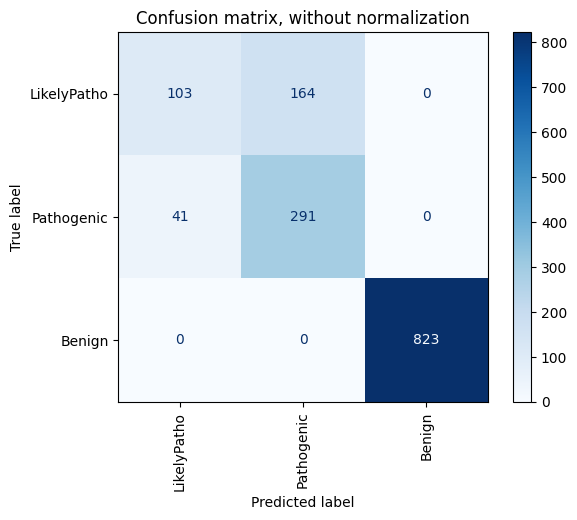

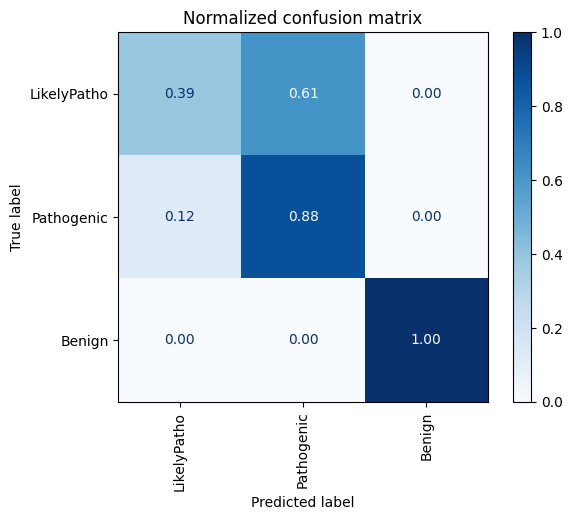

              precision    recall  f1-score   support

           0       0.77      0.40      0.53       267
           1       0.65      0.90      0.76       332
           2       1.00      1.00      1.00       823

    accuracy                           0.86      1422
   macro avg       0.81      0.77      0.76      1422
weighted avg       0.88      0.86      0.85      1422



In [ ]:
display_confusion_matrix(eclf,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

Stacking:

Training Accuracy:  0.9704641350210971
Validation Accuracy:  0.8607594936708861
F1-Score: 0.8497557189637913


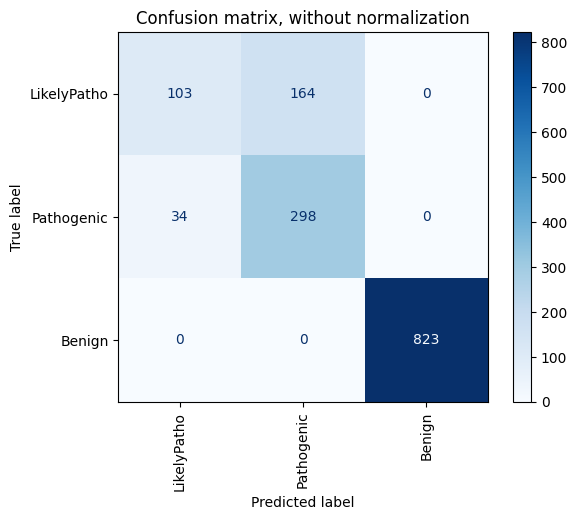

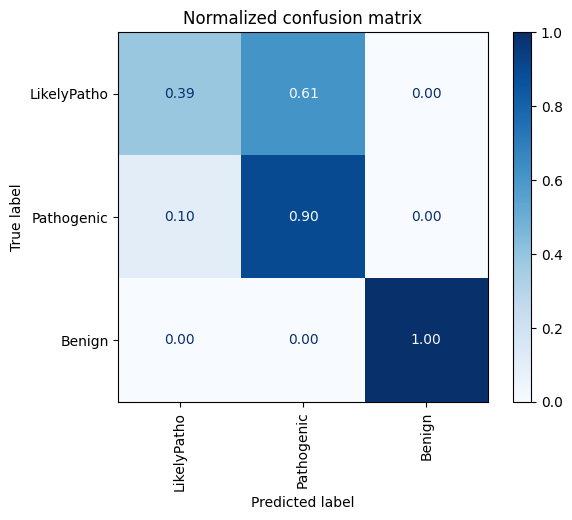

              precision    recall  f1-score   support

           0       0.75      0.39      0.51       267
           1       0.65      0.90      0.75       332
           2       1.00      1.00      1.00       823

    accuracy                           0.86      1422
   macro avg       0.80      0.76      0.75      1422
weighted avg       0.87      0.86      0.85      1422



In [ ]:
estimators = [
              # ('lr', model_lr), 
              # ('knn', model_knn), 
              # ('svc', model_svm),
             # ('gnb', model_nb),
              ('rfc', model_rfc_tuned),
              # ("xgb",model_xgb_tuned)
              ]
final_estimator = model_xgb_tuned
model_stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator,n_jobs=-1)
model_stack.fit(X_train, y_train)
y_train_pred = model_stack.predict(X_train)
y_val_pred = model_stack.predict(X_val)
print("Training Accuracy: ", np.mean(y_train_pred==y_train))
print("Validation Accuracy: ", np.mean(y_val_pred==y_val))
print("F1-Score:",f1_score(y_val,y_val_pred,average="weighted"))
display_confusion_matrix(model_stack,X_val,y_val,class_names)
print(classification_report(y_val,y_val_pred))

SAVE final XGB model (trained on full data).

In [ ]:
import pickle
try:
  pickle.dump(model_xgb_full, open('/content/drive/MyDrive/MSc-project-lof/models/model_xgb_full.pkl', 'wb'))
  print("Model saved successfully.")
except:
  print("Error occurred while saving the model.")

Model saved successfully.
